In [1]:
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from pathlib import Path
import pprint
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import itertools
import os
import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from collections import defaultdict
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import f1_score
from functools import partial
from tqdm.notebook import trange, tqdm

In [2]:
data_dir = Path('/gpfs/data/geraslab/ekr6072/projects/study_indication/data')
data_path = data_dir / 'dataset.pkl'

In [3]:
tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer")

In [4]:
with open(data_path, 'rb') as f:
  dataset = pickle.load(f)

In [5]:
def clean_dataset(dataset):
  output = {}
  for name, subset in dataset.items():
    clean_subset = []
    for data in subset:
      label = data['label']
      if label not in ['unknown']:
        clean_subset.append(data)
    output[name] = clean_subset
  return output

In [6]:
dataset = clean_dataset(dataset)

In [7]:
category2id = {
  '(high-risk) screening': 0,
  'extent of disease / pre-operative planning': 1,
  'additional workup': 2,
  '6-month follow-up / surveillance': 3,
  'exclude': 4,
  'unknown': 5,
}

In [8]:
train_texts = [data['text']['longText'] for data in dataset['train']]
train_labels = [category2id[data['label']] for data in dataset['train']]

In [9]:
val_texts = [data['text']['longText'] for data in dataset['val']]
val_labels = [category2id[data['label']] for data in dataset['val']]

In [10]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=1024)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=1024)

In [11]:
lengths = []
for sequence in train_encodings['input_ids']:
  pad = np.where(np.array(sequence) == 1)[0]
  if len(pad) == 0:
    length = len(sequence)
  else: 
    length = pad.min()
  lengths.append(length)

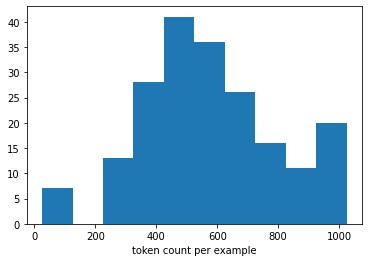

In [12]:
fig, ax = plt.subplots()
ax.hist(lengths, bins=10);
ax.set_xlabel('token count per example'); # add logits from all the classifiers and backprop through sum of the logits

In [13]:
import torch

class IndicationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IndicationDataset(train_encodings, train_labels)
val_dataset = IndicationDataset(val_encodings, val_labels)

In [14]:
train_dataloader = DataLoader(train_dataset, 16, shuffle=True)
val_dataloader = DataLoader(val_dataset, 16, shuffle=False)

In [16]:
# training
model = AutoModel.from_pretrained("yikuan8/Clinical-Longformer")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
prototypes = defaultdict(list)
with torch.no_grad():
  model.eval()
  for batch in tqdm(train_dataloader):
    batch = {key: value.to(device) for key, value in batch.items()}
    outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'])
    for i, prototype in enumerate(outputs['pooler_output']):
      label = batch['labels'][i]
      prototypes[label.item()].append(prototype)

for label, prototype in prototypes.items():
  prototypes[label] = torch.stack(prototype).mean(axis=0)

Some weights of the model checkpoint at yikuan8/Clinical-Longformer were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a dow

  0%|          | 0/13 [00:00<?, ?it/s]

In [27]:
sample = outputs['pooler_output'][0]

In [61]:
def nearest_neighbor(sample, prototypes):
  score = {}
  normalization = 0
  for label in prototypes:
    score[label] = torch.exp(-torch.linalg.norm(sample - prototypes[label]) ** 2)
    normalization += score[label]

  max_score = - float('inf')
  for label in prototypes:
    score[label] /= normalization
    if score[label] > max_score:
      prediction = label
      max_score = score[label]
  return prediction

In [62]:
def inference(model, batch, prototypes):
  with torch.no_grad():
    model.eval()
    outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'])
    predictions = []
    for i, sample in enumerate(outputs['pooler_output']):
      prediction = nearest_neighbor(sample, prototypes)
      predictions.append(prediction)
  return torch.tensor(predictions)

In [63]:
# evaluation
with torch.no_grad():
  model.eval()
  all_preds = []
  all_labels = []
  for batch in tqdm(val_dataloader):
    batch = {key: value.to(device) if key != 'labels' else value for key, value in batch.items()}
    outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'])
    predictions = inference(model, batch, prototypes)
    label = batch['labels']
    all_preds.append(predictions)
    all_labels.append(label)
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

  0%|          | 0/7 [00:00<?, ?it/s]

In [64]:
f1_score(all_labels, all_preds, average='macro')

0.2471762740183793